## Implementation of the transformer

---


This notebook contains the implementation of the transformer described in the report. Consists of different classes defining the layers and different elements of the transformer.
Data is from https://data.open-power-system-data.org/time\_series/.
The implementation is influenced from both the article "Attention Is All You Need" and the article "How to code The Transformer in Pytorch" https://towardsdatascience.com/how-to-code-the-transformer-in-pytorch-24db27c8f9ec

Mikkel Godtfredsen Feb-Jun, 2021

In [1]:
# Import libraries and module
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
from torch.autograd import Variable
from torch.utils.data import DataLoader, random_split, TensorDataset,Dataset
import torch.nn.functional as F
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
import copy
from sklearn.model_selection import GridSearchCV

In [2]:
# Import data and load into dataframe.
data = pd.read_csv("/content/drive/MyDrive/time_series_60min_singleindex_filtered.csv",parse_dates=[0])
data = pd.DataFrame(data)
# Drop single outlier and sum up columns
total_load = data[data.columns[:]].sum(axis=1)
data['total_load'] = total_load
data = data.drop(columns=data.columns[1:59])
data = data.drop([np.argmax(data['total_load'])])
data = data.drop([0]).reset_index(drop=True)
data = data.rename(columns={'utc_timestamp':'datetime'})

In [3]:
# Class to define time series dataset.
# Defines source and target sequence.
class TimeSeriesDataset(Dataset):
  def __init__(self,data,src_len,tgt_len):
    rang = len(data)-src_len-tgt_len
    self.x = torch.Tensor([data[i:(i+src_len)] for i in range(rang)])
    self.y = torch.Tensor([data[(i+src_len):(i+src_len+tgt_len)] for i in range(rang)])
    self.n_samples = self.x.shape[0]

  def __getitem__(self, index):
    return self.x[index], self.y[index]

  def __len__(self):
    return self.n_samples

In [4]:
# Class to define the positional encoding layer
class PositionalEncoder(nn.Module):
  def __init__(self, d_model, max_seq_len = 5000):
    super().__init__()
    self.d_model = d_model

    enc_matrix = torch.zeros(max_seq_len, d_model)
    for pos in range(max_seq_len):
      for i in range(0, d_model, 2):
        enc_matrix[pos, i] = np.sin(pos / (10000 ** ((2 * i)/d_model)))
        enc_matrix[pos, i + 1] = np.cos(pos / (10000 ** ((2 * (i + 1))/d_model)))
            
    enc_matrix = enc_matrix.unsqueeze(0)
    self.register_buffer('enc_matrix', enc_matrix)

  def forward(self, x):
    x = x * np.sqrt(self.d_model)
    seq_len = x.size(1)
    x = x + Variable(self.enc_matrix[:,:seq_len])
    return x

In [5]:
# Class to define attention functions, both scaled dot-product
# and multi-head attention
class MultiHeadAttention(nn.Module):
  def __init__(self, heads, d_model, dropout = 0.1,mask=None):
    super().__init__()
    
    self.d_model = d_model
    self.d_k = d_model // heads
    self.h = heads
    self.mask = mask
    
    self.q_linear = nn.Linear(d_model, d_model)
    self.v_linear = nn.Linear(d_model, d_model)
    self.k_linear = nn.Linear(d_model, d_model)

    self.dropout = nn.Dropout(dropout)
    self.out = nn.Linear(d_model, d_model)
  
  def forward(self, q, k, v, mask=None):
    bs = q.size(0)
    
    k = self.k_linear(k).view(bs, -1, self.h, self.d_k)
    q = self.q_linear(q).view(bs, -1, self.h, self.d_k)
    v = self.v_linear(v).view(bs, -1, self.h, self.d_k)
    
    k = k.transpose(1,2)
    q = q.transpose(1,2)
    v = v.transpose(1,2)

    scores = attention(q, k, v, self.d_k, mask, self.dropout)
    
    concat = scores.transpose(1,2).contiguous().view(bs, -1, self.d_model)
    
    output = self.out(concat)

    return output

def attention(q, k, v, d_k, mask=None, dropout=None): 
  scores = torch.matmul(q, k.transpose(-2, -1)) /  np.sqrt(d_k)
  
  if mask is not None:
    mask_filter = torch.tensor(np.nan_to_num((1-np.tri(scores.size(-1)))*np.inf,posinf=-np.inf)).to(device)
    scores += mask_filter
  scores = F.softmax(scores, dim=-1)
  
  if dropout is not None:
    scores = dropout(scores)
      
  output = torch.matmul(scores, v)
  return output

In [6]:
# Class to define the feed forward neural network
class FFN(nn.Module):
  def __init__(self,d_model,features,dropout=0.1):
    super(FFN,self).__init__()
    self.ff1 = nn.Linear(d_model,features)
    self.ff2 = nn.Linear(features,d_model)
    self.dropout = nn.Dropout(dropout)
  def forward(self,x):
    x = self.ff1(x)
    x = F.relu(x)
    x = self.dropout(x)
    x = self.ff2(x)
    return x

In [7]:
# Normalization layer
class Normalization(nn.Module):
  def __init__(self,d_model,eps=1e-6):
    super().__init__()
    self.a = nn.Parameter(torch.ones(d_model))
    self.b = nn.Parameter(torch.zeros(d_model))
    self.eps = eps
  def forward(self,x):
    return self.a * (x - x.mean(dim=-1, keepdim=True)) / (x.std(dim=-1, keepdim=True) + self.eps) + self.b

In [8]:
# Defining the encoder layer
class EncoderLayer(nn.Module):
  def __init__(self,d_model,nheads,dropout = 0.1):
    super().__init__()
    self.norm1 = Normalization(d_model)
    self.norm2 = Normalization(d_model)
    self.attention = MultiHeadAttention(nheads,d_model)
    self.ffn = FFN(d_model,4*d_model)
    self.dropout1 = nn.Dropout(dropout)
    self.dropout2 = nn.Dropout(dropout)
  def forward(self,x):
    x2 = self.norm1(x)
    x = x + self.dropout1(self.attention(x2,x2,x2))
    x2 = self.norm2(x)
    x = x + self.dropout2(self.ffn(x2))
    return x 

In [9]:
# Defining the decoder layer
class DecoderLayer(nn.Module):
  def __init__(self,d_model,nheads,dropout = 0.1):
    super().__init__()
    self.norm1 = Normalization(d_model)
    self.norm2 = Normalization(d_model)
    self.norm3 = Normalization(d_model)
    self.attention1 = MultiHeadAttention(nheads,d_model,mask=True)
    self.attention2 = MultiHeadAttention(nheads,d_model)
    self.ffn = FFN(d_model,4*d_model)
    self.dropout1 = nn.Dropout(dropout)
    self.dropout2 = nn.Dropout(dropout)
    self.dropout3 = nn.Dropout(dropout)

  def forward(self,x,outputs):
    x2 = self.norm1(x)
    x = x + self.dropout1(self.attention1(x2,x2,x2,mask=True))
    x2 = self.norm2(x)
    x = x + self.dropout2(self.attention2(x2,outputs,outputs))
    x2 = self.norm3(x)
    x = x + self.dropout3(self.ffn(x2))
    return x

In [10]:
# Function to copy n encoder/decoder layers
def sublayers(module, n):
  return nn.ModuleList([copy.deepcopy(module) for i in range(n)])

In [11]:
# Defining the encoder
class Encoder(nn.Module):
  def __init__(self,features,d_model,n,nheads):
    super().__init__()
    self.n = n
    self.embedding = nn.Linear(features,d_model)
    self.positionalencoding = PositionalEncoder(d_model)
    self.layers = sublayers(EncoderLayer(d_model,nheads),n)
    self.norm = Normalization(d_model)

  def forward(self,x):
    x = self.embedding(x)
    x = self.positionalencoding(x)
    for i in range(self.n):
      x = self.layers[i](x)
    return self.norm(x)

In [12]:
# Defining the decoder
class Decoder(nn.Module):
  def __init__(self,features,d_model,n,nheads):
    super().__init__()
    self.n = n
    self.embedding = nn.Linear(features,d_model)
    self.positionalencoding = PositionalEncoder(d_model)
    self.layers = sublayers(DecoderLayer(d_model,nheads),n)
    self.norm = Normalization(d_model)

  def forward(self,y,encoderoutputs):
    x = self.embedding(y)
    x = self.positionalencoding(x)
    for i in range(self.n):
      x = self.layers[i](x,encoderoutputs)
    return self.norm(x)

In [13]:
# Defining the transformer, built from a combination
# of previous modules
class Transformer(nn.Module):
  def __init__(self,d_model,n,nheads,xsize=1,ysize=1):
    super(Transformer,self).__init__()
    self.encoder = Encoder(xsize,d_model,n,nheads)
    self.decoder = Decoder(ysize,d_model,n,nheads)
    self.out = nn.Linear(d_model,ysize)
    
  def forward(self,x,y):
    encoderoutput = self.encoder(x)
    decoderoutput = self.decoder(y,encoderoutput)
    output = self.out(decoderoutput)
    return output

In [14]:
cuda = True # Set this if training on GPU
cuda = cuda and torch.cuda.is_available()
device = torch.device("cuda" if cuda else "cpu")
print("Using "+repr(device))

Using device(type='cuda')


In [15]:
# Subsample the dataset for experiments
data_hourly = data.set_index('datetime')
data_monthly = data_hourly.resample('M').sum()
data_weekly = data_hourly.resample('W').sum()
data_daily = data_hourly.resample('D').sum()

# Choose which data representation to use
data_used = data_daily

# Scale the data
scaler = MinMaxScaler(feature_range=(0,1))
data_normalized = scaler.fit_transform(data_used)

# Split data into training, validation, and test sets
train_size,val_size = 0.6,0.2
train,val,test = data_normalized[:int(train_size*len(data_normalized))], data_normalized[int(train_size*len(data_normalized)):int((train_size+val_size)*len(data_normalized))],data_normalized[int((train_size+val_size)*len(data_normalized)):]

# Create time series dataset and dataloaders
batch_size = len(train)%64 and len(val)%64
src_len, tgt_len = 50,25
train, val, test = TimeSeriesDataset(train,src_len, tgt_len), TimeSeriesDataset(val,src_len, tgt_len), TimeSeriesDataset(test,src_len, tgt_len)
dataloader_train = DataLoader(dataset=train,batch_size=batch_size,shuffle=False,num_workers=0)
dataloader_val = DataLoader(dataset=val,batch_size=batch_size,shuffle=False,num_workers=0)
dataloader_test = DataLoader(dataset=test,batch_size=batch_size,shuffle=False,num_workers=0)

In [16]:
# Define the model, loss function, and optimizer
transformer = Transformer(128,6,8).to(device)
loss = nn.MSELoss()
optimizer = torch.optim.Adam(transformer.parameters(),lr=0.0001)

# Initialize parameters
for p in transformer.parameters():
  if p.dim() > 1:
    nn.init.xavier_uniform_(p)

# Define epochs, variable for adaptive stopping, and patience
epochs = 200
best_loss = 100
patience = 10

# Training loop
train_losses = []
val_losses = []
for i in range(epochs):
  tr_loss = 0
  transformer.train()
  for j, (src,tgt) in enumerate(dataloader_train):
    x, y = src.to(device),tgt.to(device)
    out = transformer(x,y)
    optimizer.zero_grad()
    train_loss = loss(out,y)
    train_loss.backward()
    optimizer.step()
    tr_loss += train_loss.item()
  tr_loss /= train.n_samples/batch_size
  train_losses.append(tr_loss)

  transformer.eval()
  validation_loss = 0
  with torch.no_grad():
    for i, (src_val, tgt_val) in enumerate(dataloader_val):
      x_val, y_val = src_val.to(device), tgt_val.to(device)
      out_val = transformer(x_val,y_val)
      validation_loss += loss(out_val,y_val)

    validation_loss /= val.n_samples/batch_size
    val_losses.append(validation_loss)
    val_loss = validation_loss

    if val_loss < best_loss:
      best_loss = val_loss
      count = 0
      best_params = transformer.state_dict()
    else:
      count += 1
      if count >= patience:
        transformer.load_state_dict(best_params)
        break

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:42: RuntimeWarning: invalid value encountered in multiply


In [17]:
# Define evaluation function
def predict(dataloader):
  with torch.no_grad():
    predictions = np.array([])
    actuals = np.array([])
    for i, data in enumerate(dataloader):
      x, y = data
      src, tgt = x.to(device),y.to(device)
      out = transformer(src,tgt)
      predictions = np.append(predictions,out.cpu().detach().numpy())
      actuals = np.append(actuals,y)
    return predictions.reshape(val.n_samples,-1), actuals.reshape(val.n_samples,-1)

In [18]:
# Evaluate the model
transformer.eval()
predictions,actuals = predict(dataloader_test)

error = np.abs(predictions - actuals)
avg_error = np.mean(error,axis=0)

predictions = scaler.inverse_transform(predictions)
actuals = scaler.inverse_transform(actuals)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:42: RuntimeWarning: invalid value encountered in multiply


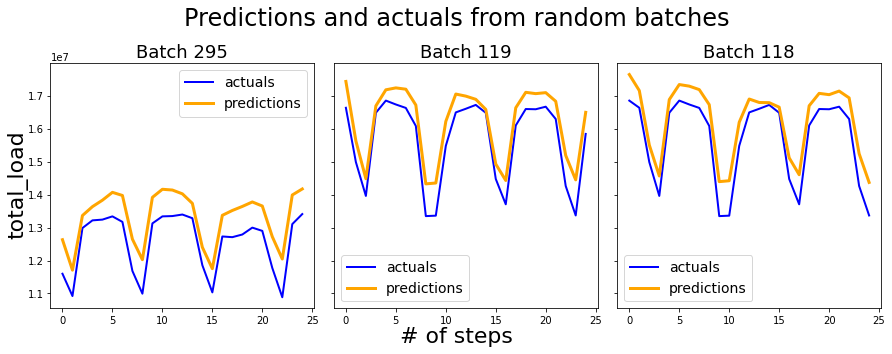

In [20]:
# Plot predictions and actual data from random batches
fig, ax = plt.subplots(2,2,figsize=(12,8),constrained_layout=True,sharex=True,sharey=True)
fig.text(0.5, -0.05, '# of steps', ha='center',fontsize=22)
fig.text(-0.02, 0.5, 'total_load', va='center', rotation='vertical',fontsize=22)
fig.text(0.5,1.05,'Predictions and actuals from random batches',ha='center',fontsize=24)
for i in range(4):
  idx = np.random.randint(0,len(predictions))
  ax[i//2,i%2].plot(actuals[idx,:],c='blue',label='actuals',linewidth=2.0)
  ax[i//2,i%2].plot(predictions[idx,:],c='orange',label='predictions',linewidth=3.0)
  ax[i//2,i%2].set_title("Batch {}".format(idx),fontsize=18)
  ax[i//2,i%2].legend(fontsize=14)
  #ax[i].plot(actuals[idx,:],c='blue',label='actuals',linewidth=2.0)
  #ax[i].plot(predictions[idx,:],c='orange',label='predictions',linewidth=3.0)
  #ax[i].set_title("Batch {}".format(idx),fontsize=18)
  #ax[i].legend(fontsize=14)
plt.show()
# Uncomment below to save figures
#plt.savefig('transformerpredictionsgood3.png',bbox_inches='tight')

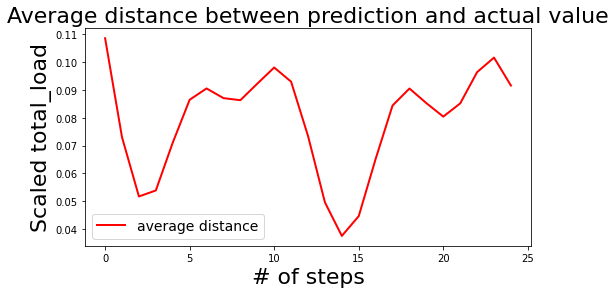

In [21]:
fig = plt.figure(figsize=(8,4))
plt.plot(avg_error,label='average distance',c='red',linewidth=2.0)
plt.title('Average distance between prediction and actual value',fontsize=22)
plt.ylabel('Scaled total_load',fontsize=22)
plt.xlabel('# of steps',fontsize=22)
plt.legend(fontsize=14)
plt.show()
# Uncomment below to save figures
#plt.savefig('avgerrortransformer.png',bbox_inches='tight')

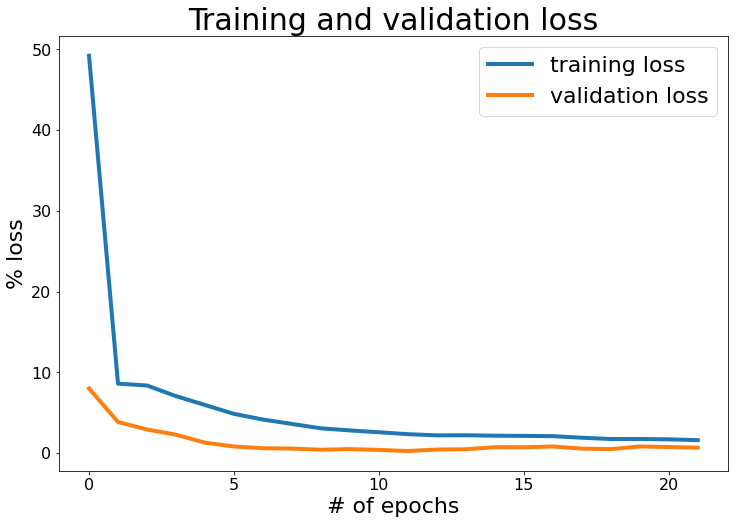

In [22]:
# Plot training and validation loss
fig = plt.figure(figsize=(12,8))
plt.plot(np.array(train_losses)*100,label='training loss',linewidth=4.0)
plt.plot(np.array(val_losses)*100, label='validation loss',linewidth=4.0)
plt.xlabel('# of epochs',size=22)
plt.ylabel('% loss',size=22)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.title('Training and validation loss',size=30)
plt.legend(fontsize=22)
# Uncomment below to save figures
#plt.savefig('transformerlossgood.png',bbox_inches='tight')